# **COMPONENTE 1:** DATA FETCHING

## **IMPORTACIÓN DE LIBRERÍAS**




In [1]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 17.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=e633ae24cb9aa8e5600d21b224f7fbc22c39a5cda61e32225c7bd4f7d01183e1
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [70]:
import tweepy

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import emoji

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.tokenize import word_tokenize

from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet
from nltk.corpus import stopwords

from nltk import pos_tag

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer

nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

## **CREDENCIALES DE ACCESO A LA API DE TWITTER**

In [72]:
TWITTER_CONSUMER_KEY = 'e27sd02R39EIsSHfrTUCiOwXT'
TWITTER_CONSUMER_SECRET = 'X0K7qJC7lZ9An1NXWJ3yYijOp4tAFPWcd3OjcBP15djPe9m5KZ'
TWITTER_ACCESS_TOKEN = '175984347-MCv5cbRKRBxXOFKDUfsQVtGhuPy42aRDn53UWP4L'
TWITTER_ACCESS_TOKEN_SECRET = 'XMEe25XGwoeozruLf9Y1zK5wYlTup9U0xLHLG4BT3JffE'

In [73]:
auth = tweepy.OAuthHandler(TWITTER_CONSUMER_KEY, TWITTER_CONSUMER_SECRET)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit = True)

## **FUNCIÓN PARA EL FETCHING DE TWEETS** 

In [69]:
def scrape(words, date_since, numtweet):
 
  #CREACIÓN DE LAS COLUMNAS DEL DATAFRAME QUE CONTENDRÁ LOS TWEETS
  db = pd.DataFrame(columns=[ 'Texto del Tweet',
                              'Autor',
                              'Fecha del Tweet',
                              'Favoritos',
                              'Retweets'])

  #REALIZACIÓN DE LA BÚSQUEDA DE LOS TWEETS UTILIZANDO LOS PARÁMETROS
  #REQUERIDOS POR LA FUNCIÓN
  tweets = tweepy.Cursor(api.search,
                          q=words, lang="en",
                          since_id=date_since,
                          tweet_mode='extended',
                          ).items(numtweet)

  #ALMACENAMIENTO TEMPORAL DE LOS TWEETS SCRAPEADOS EN UNA LISTA
  list_tweets = [tweet for tweet in tweets]

  #RECORRIDO DE LA LISTA DE TWEETS EN EL QUE SE EXTRAERÁ LA INFORMACIÓN
  #BUSCADA DE CADA UNO DE ESTOS
  i = 1
  ids = []
  for tweet in list_tweets:

    try:
      if    hasattr(tweet, 'retweeted_status'):
        text = tweet.retweeted_status.full_text
      elif  hasattr(tweet, 'tweeted_status'):
        text = tweet.tweeted_status.full_text
      else:
        text = ""
    except AttributeError as error:
      print(str(error))

    autor = tweet.user.screen_name
    retweets = tweet.retweet_count

    entidades = tweet.entities

    id_tweet = tweet._json['id']
    ids.append(id_tweet)
    
    fecha_tweet = tweet._json['created_at']

    tweet = api.get_status(id_tweet)
    favoritos = tweet.favorite_count

    #ASIGNACIÓN DE LOS VALORES EXTRAÍDOS DEL TWEET A UNA LISTA TEMPORAL
    ith_tweet =   [text, autor,
                  fecha_tweet, favoritos,
                  retweets]

    #VERIFICACIÓN DE QUE NO SE ENCUENTREN CAMPOS VACIÓS EN LA COLUMNA DE TEXTO
    if ith_tweet[0] != "":
      db.loc[len(db)] = ith_tweet
    else:
      continue
  
  #ELIMINACIÓN DE LAS OBSERVACIONES CON CAMPOS VACÍOS
  db.dropna()

  return db
   

## **CREACIÓN DEL .CSV CON LOS DATOS ORIGINALES DE LOS TWEETS**

In [75]:
nombre_archivo_salida = "tweets_scrapeados_original.csv"
cant_tweets_a_scrapear = 1000
fecha_inicio_busqueda = "2020-01-01"
palabra_a_buscar = "#hardware"

df_tweets_original = scrape(palabra_a_buscar, fecha_inicio_busqueda, cant_tweets_a_scrapear)
df_tweets_original.to_csv(nombre_archivo_salida)

# **COMPONENTE 2:** DATA ANALYSIS

## **LECTURA DEL .CSV DE ENTRADA (RESULTADO COMPONENTE 1)**

In [86]:
df_tweets_analisis = pd.read_csv("tweets_scrapeados_original.csv")


## **LIMPIEZA DE DATOS**

### Limpieza de caracteres especiales

In [87]:
def cleanTxt(text):
 text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
 text = re.sub('#', '', text) # Removing '#' hash tag
 text = re.sub('RT[\s]+', '', text) # Removing RT
 text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
 
 return text

df_tweets_analisis['Texto limpiado'] = df_tweets_analisis['Texto del Tweet'].apply(cleanTxt)

df_tweets_analisis.head()

,Unnamed: 0,Texto del Tweet,Autor,Fecha del Tweet,Favoritos,Retweets,Texto limpiado
0,0,9 pulls knobs Salvage no sets Vintage by raref...,MormorJan,Mon Jun 20 20:40:14 +0000 2022,0,6,9 pulls knobs Salvage no sets Vintage by raref...
1,1,@dSPACEglobal to Showcase a Variety of Hardwar...,dSPACEglobal,Mon Jun 20 20:16:36 +0000 2022,0,1,to Showcase a Variety of Hardware and Softwar...
2,2,"Meta's new Avatar Store is 10 years too late, ...",cooltechrobot,Mon Jun 20 20:08:24 +0000 2022,0,1,"Meta's new Avatar Store is 10 years too late, ..."
3,3,Excited to share my first foray into music-mak...,narraloc,Mon Jun 20 19:17:52 +0000 2022,0,2769,Excited to share my first foray into music-mak...
4,4,📚 Exploring Arduino Tools and Techniques for E...,AndresReyes_Mzt,Mon Jun 20 18:57:16 +0000 2022,0,2,📚 Exploring Arduino Tools and Techniques for E...


### Limpieza de caracteres del tipo emoji

In [88]:
#ELIMINACIÓN DE LOS EMOJIS
def borrarEmojis(text):
  regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticones
        u"\U0001F300-\U0001F5FF"  # símbolos
        u"\U0001F680-\U0001F6FF"  # símbolos de transporte
        u"\U0001F1E0-\U0001F1FF"  # banderas
                           "]+", flags = re.UNICODE)

  return regrex_pattern.sub(r'',text)

df_tweets_analisis['Texto limpiado']  = df_tweets_analisis['Texto limpiado'] .apply(borrarEmojis)


### Limpieza de todo otro tipo de caracter

In [91]:
def clean(text):
    #Filtro de Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-zÁÉÍÓÚáéíóú]+', ' ', text) 
    return text

df_tweets_analisis['Texto limpiado']  = df_tweets_analisis['Texto limpiado'].apply(clean)

In [92]:
df_tweets_analisis.head()

,Unnamed: 0,Texto del Tweet,Autor,Fecha del Tweet,Favoritos,Retweets,Texto limpiado
0,0,9 pulls knobs Salvage no sets Vintage by raref...,MormorJan,Mon Jun 20 20:40:14 +0000 2022,0,6,pulls knobs Salvage no sets Vintage by rarefi...
1,1,@dSPACEglobal to Showcase a Variety of Hardwar...,dSPACEglobal,Mon Jun 20 20:16:36 +0000 2022,0,1,to Showcase a Variety of Hardware and Softwar...
2,2,"Meta's new Avatar Store is 10 years too late, ...",cooltechrobot,Mon Jun 20 20:08:24 +0000 2022,0,1,Meta s new Avatar Store is years too late look...
3,3,Excited to share my first foray into music-mak...,narraloc,Mon Jun 20 19:17:52 +0000 2022,0,2769,Excited to share my first foray into music mak...
4,4,📚 Exploring Arduino Tools and Techniques for E...,AndresReyes_Mzt,Mon Jun 20 18:57:16 +0000 2022,0,2,Exploring Arduino Tools and Techniques for En...


## **ELIMINACION DE CONECTORES**

### Instancimiento de las palabras de conexión en el idioma utilizado

In [93]:
idioma_tweets = "english"
stop_words = stopwords.words(idioma_tweets)

### Aplicación de la función de eliminación de conectores

In [94]:
def eliminarConectores(texto):
  palabras = texto.split(sep=" ")
  for palabra in palabras:
    if palabra.lower() in stop_words:
      palabras.remove(palabra)
  
  tweetLimpio = " ".join(palabras)

  return tweetLimpio

df_tweets_analisis['Texto limpiado']  = df_tweets_analisis['Texto limpiado'] .apply(eliminarConectores)
df_tweets_analisis.head()

,Unnamed: 0,Texto del Tweet,Autor,Fecha del Tweet,Favoritos,Retweets,Texto limpiado
0,0,9 pulls knobs Salvage no sets Vintage by raref...,MormorJan,Mon Jun 20 20:40:14 +0000 2022,0,6,pulls knobs Salvage sets Vintage rarefinds u ...
1,1,@dSPACEglobal to Showcase a Variety of Hardwar...,dSPACEglobal,Mon Jun 20 20:16:36 +0000 2022,0,1,Showcase Variety Hardware Software Solutions ...
2,2,"Meta's new Avatar Store is 10 years too late, ...",cooltechrobot,Mon Jun 20 20:08:24 +0000 2022,0,1,Meta new Avatar Store years late looks outdate...
3,3,Excited to share my first foray into music-mak...,narraloc,Mon Jun 20 19:17:52 +0000 2022,0,2769,Excited share first foray music making hardwar...
4,4,📚 Exploring Arduino Tools and Techniques for E...,AndresReyes_Mzt,Mon Jun 20 18:57:16 +0000 2022,0,2,Exploring Arduino Tools Techniques Engineerin...


## **TOKENIZATION, POS TAGGING, STOPWORDS REMOVAL**

In [95]:
# CLASIFICACIÓN DE PALABRAS UTILIZANDO EL POS TAGGING 
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words(idioma_tweets)):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

df_tweets_analisis['POS tagged'] = df_tweets_analisis['Texto limpiado'].apply(token_stop_pos)
df_tweets_analisis.head()

,Unnamed: 0,Texto del Tweet,Autor,Fecha del Tweet,Favoritos,Retweets,Texto limpiado,POS tagged
0,0,9 pulls knobs Salvage no sets Vintage by raref...,MormorJan,Mon Jun 20 20:40:14 +0000 2022,0,6,pulls knobs Salvage sets Vintage rarefinds u ...,"[(pulls, n), (knobs, v), (Salvage, n), (sets, ..."
1,1,@dSPACEglobal to Showcase a Variety of Hardwar...,dSPACEglobal,Mon Jun 20 20:16:36 +0000 2022,0,1,Showcase Variety Hardware Software Solutions ...,"[(Showcase, n), (Variety, n), (Hardware, n), (..."
2,2,"Meta's new Avatar Store is 10 years too late, ...",cooltechrobot,Mon Jun 20 20:08:24 +0000 2022,0,1,Meta new Avatar Store years late looks outdate...,"[(Meta, n), (new, a), (Avatar, n), (Store, n),..."
3,3,Excited to share my first foray into music-mak...,narraloc,Mon Jun 20 19:17:52 +0000 2022,0,2769,Excited share first foray music making hardwar...,"[(Excited, n), (share, n), (first, a), (foray,..."
4,4,📚 Exploring Arduino Tools and Techniques for E...,AndresReyes_Mzt,Mon Jun 20 18:57:16 +0000 2022,0,2,Exploring Arduino Tools Techniques Engineerin...,"[(Exploring, v), (Arduino, n), (Tools, n), (Te..."


## **SEGMENTACIÓN USANDO SENTIWORDNET**

In [96]:
def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue
        
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1

    if not tokens_count:
        return 0
    if sentiment>0:
        return "Positive"
    if sentiment==0:
        return "Neutral"
    else:
        return "Negative"

df_tweets_analisis['SWN analysis'] = df_tweets_analisis['POS tagged'].apply(sentiwordnetanalysis)
df_tweets_analisis.head()

,Unnamed: 0,Texto del Tweet,Autor,Fecha del Tweet,Favoritos,Retweets,Texto limpiado,POS tagged,SWN analysis
0,0,9 pulls knobs Salvage no sets Vintage by raref...,MormorJan,Mon Jun 20 20:40:14 +0000 2022,0,6,pulls knobs Salvage sets Vintage rarefinds u ...,"[(pulls, n), (knobs, v), (Salvage, n), (sets, ...",Positive
1,1,@dSPACEglobal to Showcase a Variety of Hardwar...,dSPACEglobal,Mon Jun 20 20:16:36 +0000 2022,0,1,Showcase Variety Hardware Software Solutions ...,"[(Showcase, n), (Variety, n), (Hardware, n), (...",Positive
2,2,"Meta's new Avatar Store is 10 years too late, ...",cooltechrobot,Mon Jun 20 20:08:24 +0000 2022,0,1,Meta new Avatar Store years late looks outdate...,"[(Meta, n), (new, a), (Avatar, n), (Store, n),...",Positive
3,3,Excited to share my first foray into music-mak...,narraloc,Mon Jun 20 19:17:52 +0000 2022,0,2769,Excited share first foray music making hardwar...,"[(Excited, n), (share, n), (first, a), (foray,...",Positive
4,4,📚 Exploring Arduino Tools and Techniques for E...,AndresReyes_Mzt,Mon Jun 20 18:57:16 +0000 2022,0,2,Exploring Arduino Tools Techniques Engineerin...,"[(Exploring, v), (Arduino, n), (Tools, n), (Te...",Positive


In [97]:
swn_counts= df_tweets_analisis['SWN analysis'].value_counts()
swn_counts

Positive    306
Neutral     102
Negative     66
Name: SWN analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x7fc6a4d61e50>,
 [Text(-0.5077773302854934, 1.0318246861013438, 'Positive'),
  Text(0.021870424679260907, -1.0997825623841966, 'Neutral'),
  Text(0.9964244374501305, -0.46598105160209136, 'Negative')],
 [Text(-0.2870045779874528, 0.5832052573616291, '64.6%'),
  Text(0.01192932255232413, -0.5998813976641071, '21.5%'),
  Text(0.5435042386091621, -0.2541714826920498, '13.9%')])

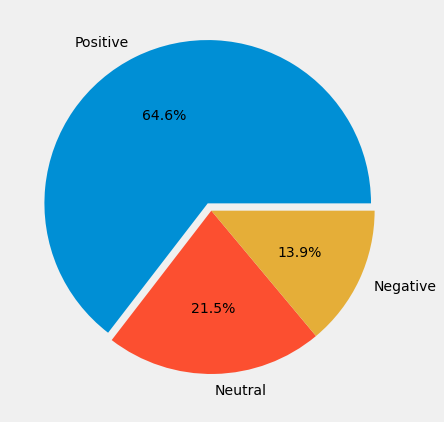

In [98]:
swn_counts= df_tweets_analisis['SWN analysis'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(swn_counts.values, labels = swn_counts.index, explode = (0.05, 0, 0), autopct='%1.1f%%', shadow=False)
# plt.legend()

## **EXPORTACIÓN DEL DATAFRAME RESULTANTE A ARCHIVO EN FORMATO .CSV**

In [99]:
nombre_archivo_salida = "tweets_scrapeados_analizados.csv"
df_tweets_analisis.to_csv(nombre_archivo_salida)